<a href="https://colab.research.google.com/github/Idelsohn/Real-world-application/blob/main/first_project_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explantation -
This is the second notebook of the project which includes the modeling itself and it hyperparameters improvement.
This model uses the data from the previous notebook

# Imports

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


### Sklearn libraries
from sklearn.preprocessing import LabelEncoder
# Encoders
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
# Feature selection
from sklearn.feature_selection import mutual_info_classif


!pip install catboost
#################### Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

#################### Actions
from sklearn import set_config
import os
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

#
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
RANDOM_STATE = 42
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import  confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.9 MB/s eta 0:00:00


In [ ]:
BASE_PATH_CSV = "/content/sample_data/Project_Intake_Sheet.csv"
# Read the csv file
data = pd.read_csv(BASE_PATH_CSV)

# Filtering the data to contain only Cancelled and
TARGET = 'Request Status'

In [ ]:
# Configuration
target_col = data[TARGET]
train = data.drop(columns = [TARGET])
X_train, X_temp, y_train, y_temp = train_test_split(train, target_col, test_size=0.3, random_state=RANDOM_STATE, stratify=target_col)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=RANDOM_STATE, stratify=y_temp)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(1135, 45)
(292, 45)
(195, 45)
Request Status
0    818
1    317
Name: count, dtype: int64
Request Status
0    141
1     54
Name: count, dtype: int64


# Adversarial Validation
Adversarial Validation is a very clever and very simple way to let us know if our test data and our training data are similar

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

X =  pd.concat([X_train, X_test], axis=0)
y = [0] * len(X_train) + [1] * len(X_test)

model = XGBClassifier(random_state=RANDOM_STATE)
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1, method='predict_proba')

score = roc_auc_score(y_true=y, y_score=cv_preds[:,1])
print(f"roc-auc score: {score:0.3f}")

roc-auc score: 0.474


Since the roc-auc score is about 0.5, we have a confirmation that train and test are from the same distribution

# **Baseline** - creating a deafult baseline model
Created two baselines -

1)  an estimation of f1 score across different models

2) LGBM model with no hyperparameter tuning but with class weights

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
classifiers = [
    CatBoostClassifier(verbose = False),
    LGBMClassifier(),
    XGBClassifier()
]
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train,
        scoring = "f1", cv = cv, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({
    "CrossValMeans":cv_means,
    "CrossValerrors": cv_std,
    "Algorithm":["CatBoostClassifier", "LGBMClassifier", "XGBClassifier"]
})

cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.248200,0.056147,CatBoostClassifier
1,0.367123,0.059050,LGBMClassifier
2,0.327074,0.077987,XGBClassifier


# Creating first prediction

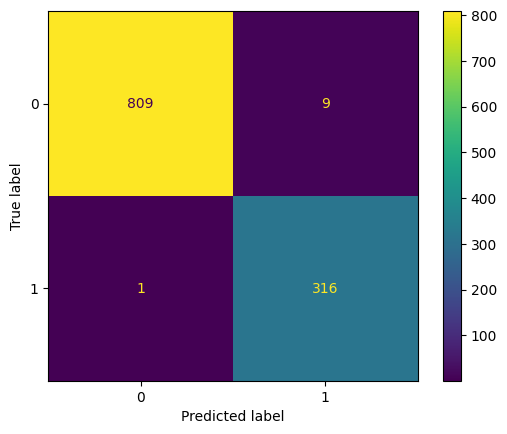

In [ ]:
from sklearn.datasets import make_classification
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1. Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# 2. Create and train the model with class weights
model = LGBMClassifier(class_weight=class_weights_dict ,random_state=42, verbose = -1)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
cm_ensemble = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble)
disp.plot()
plt.show()


# Feature improtance plot

<ipython-input-12-6bf95ccd349d>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


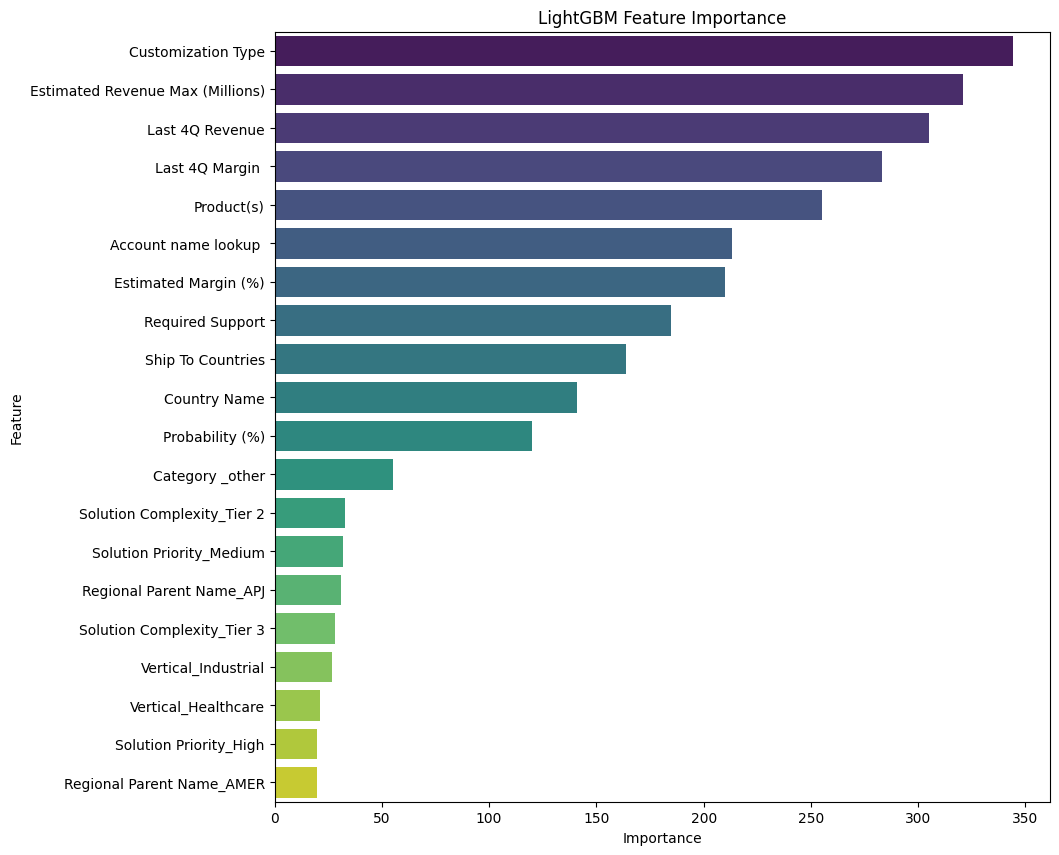

In [ ]:
def plot_feature_importance(model, feature_names=None, top_n=20, plot=True):

    # Get feature importance
    feature_importance = model.feature_importances_

    # Get feature names
    if feature_names is None:
        feature_names = model.feature_name()

    # Create DataFrame with feature names and importance scores
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Sort by importance and select top features
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    # Plot the feature importance
    if plot:
        plt.figure(figsize=(10, 10))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
        plt.title('LightGBM Feature Importance')
        plt.show()

    return feature_importance_df

feature_importance_df = plot_feature_importance(model,feature_names=X_train.columns)

# Evaluation of the test data

Accuracy: 0.678082191780822
Recall: 0.36585365853658536
Precision: 0.4166666666666667
F1-Score: 0.38961038961038963


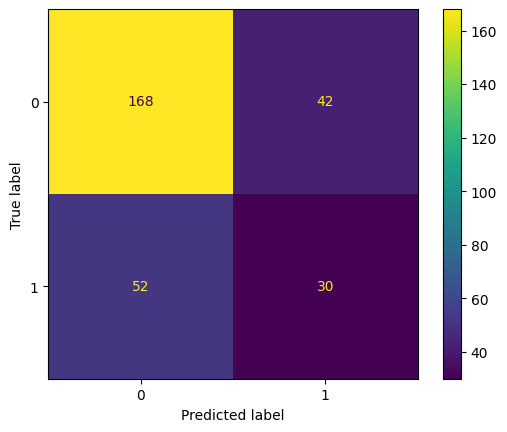

In [ ]:
# 5. Evaluation with emphasis on the minority class
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

y_pred = model.predict(X_val)

print('Accuracy:', accuracy_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('Precision:', precision_score(y_val, y_pred))
print('F1-Score:', f1_score(y_val, y_pred))


cm_ensemble = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble)
disp.plot()
plt.show()

# Shap Values and premutation score
after the failure of the evalution to predict the result at a level that does not resemble at all the classification of the train set there is a need to

In [ ]:
!pip install shap
import shap
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

clf = LGBMClassifier()
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_val)

# Classification Report
print(classification_report(y_pred, y_val))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.6 MB/s eta 0:00:00
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 317, number of negative: 818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 1135, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.279295 -> initscore=-0.947961
[LightGBM] [Info] Start training from score -0.947961
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       245
           1       0.26      0.45      0.33        47

    accuracy                           0.70       292
   macro avg       0.57      0.60      0.57       292
weighted avg  

# Hyperparameters tuning

## LGBM Optuna Hyperparameters tuning
tuning LGBM parameters using Optuna library

In [ ]:
!pip install optuna
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score  # Or other suitable metric

def objective_lgbm(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.3, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 0.1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-1, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
    }
    lgbParams = {
        'is_unbalance': True,
        'random_state': 42,
        'metric': 'binary_logloss', # binary metric
        "boosting_type": "gbdt", # Can experiment with other types
        'objective': 'binary', # For binary classification
    }

    LGBM_model = lgb.LGBMClassifier(**params, **lgbParams)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(LGBM_model, X_train, y_train, cv=cv, scoring='f1', return_train_score=False)

    score = cv_results['test_score'].mean()
    return score

# Assuming you have your data in 'X_train' and 'y_train'

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective_lgbm, n_trials=50)

best_params = study.best_params
print("Best Hyperparameters for LGBM:", best_params)

optuna.visualization.plot_param_importances(study)

In [ ]:
optuna_LGBM = {
               'max_depth': 13,
               'num_leaves': 147,
               'learning_rate': 0.4500756157117973,
               'feature_fraction': 0.7301992104097964,
               'bagging_fraction': 0.9359450585018844,
               'bagging_freq': 6, 'reg_alpha': 0.018888660125774434,
               'reg_lambda': 0.1399392554580834,
               'colsample_bytree': 0.7185635561648196,
               'subsample': 0.9130070661805147,
               'min_child_samples': 23
               }
lgbm_model = LGBMClassifier(**optuna_LGBM)
lgbm_model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('F1-Score:', f1_score(y_test, y_pred))


cm_ensemble = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble)
disp.plot()
plt.show()

## XGBoost Optuna